In [ ]:
# @title Install dependencies
!pip install pandas --quiet
!pip install seaborn --quiet
!pip install nilearn --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, datasets

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [ ]:
# @title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
## The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
import os, requests, tarfile
fname = "hcp_task.tgz"
url = "https://osf.io/s4h8j/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")


In [ ]:
fname_ex = "hcp_task"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

File hcp_task.tgz has already been extracted.


In [ ]:
regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

In [ ]:
def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = EXPERIMENTS[experiment]['runs'][run]
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           str(task_key), f"{cond}.txt")

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [ ]:
my_exp = 'WM'
my_subj = subjects[8]
my_run = 1
my_subj
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              dir=os.path.join(HCP_DIR, "hcp_task"),
                              remove_mean=True)
print(data.shape)

(360, 405)


In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))
print(evs)
print(len(evs))

[[array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88])], [array([308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346])], [array([347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385])], [array([149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187])], [array([209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 2

In [ ]:
# MEAN VERSION

def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.array([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))]).reshape((360,))

X_mean_act, y_mean_act = [], []
my_exp = 'WM'
my_dir = os.path.join(HCP_DIR, "hcp_task")
my_conditions = ['body','faces','places','tools']
for my_subj in range(N_SUBJECTS):
  for my_run in range(N_RUNS):
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=my_dir)
    for cond in my_conditions:
      zerobk_activity = average_frames(data, evs, my_exp, f'0bk_{cond}')
      twobk_activity = average_frames(data, evs, my_exp, f'2bk_{cond}')
      X_mean_act.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':zerobk_activity, })
      X_mean_act.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':twobk_activity, })
      y_mean_act.append('0bk')
      y_mean_act.append('2bk')
X_mean_act = np.vstack(pd.DataFrame.from_dict(X_mean_act).to_numpy()[:, -1])
y_mean_act = np.vstack(pd.DataFrame.from_dict(y_mean_act).to_numpy()).reshape(-1)

In [ ]:
X_mean_act.shape

(5424, 360)

In [ ]:
y_mean_act

array(['0bk', '2bk', '0bk', ..., '2bk', '0bk', '2bk'], dtype=object)

In [ ]:
#@ MAXiMUM VERSION
def maximum_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.array([np.max(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))]).reshape((360,))

X_max_act, y_max_act, X_max_act_test, y_max_act_test = [], [], [], []
my_exp = 'WM'
my_dir = os.path.join(HCP_DIR, "hcp_task")
my_conditions = ['body','faces','places','tools']
for my_subj in range(35,340):
  for my_run in range(N_RUNS):
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=my_dir)
    for cond in my_conditions:
      zerobk_activity = average_frames(data, evs, my_exp, f'0bk_{cond}')
      twobk_activity = average_frames(data, evs, my_exp, f'2bk_{cond}')
      X_max_act.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':zerobk_activity, })
      X_max_act.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':twobk_activity, })
      y_max_act.append('0')
      y_max_act.append('1')
for my_subj in range(0,35):
  for my_run in range(N_RUNS):
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=my_dir)
    for cond in my_conditions:
      zerobk_activity = average_frames(data, evs, my_exp, f'0bk_{cond}')
      twobk_activity = average_frames(data, evs, my_exp, f'2bk_{cond}')
      X_max_act_test.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':zerobk_activity, })
      X_max_act_test.append({'subject': my_subj, 'condition': cond, 'run': my_run, 'activity':twobk_activity, })
      y_max_act_test.append('0')
      y_max_act_test.append('1')
X_max_act = np.vstack(pd.DataFrame.from_dict(X_max_act).to_numpy()[:, -1])
y_max_act = np.vstack(pd.DataFrame.from_dict(y_max_act).to_numpy()).reshape(-1)
y_max_act.astype(int)
X_max_act_test = np.vstack(pd.DataFrame.from_dict(X_max_act_test).to_numpy()[:, -1])
y_max_act_test = np.vstack(pd.DataFrame.from_dict(y_max_act_test).to_numpy()).reshape(-1)
y_max_act_test.astype(int)

FileNotFoundError: ignored

In [ ]:
X_max_act_model

[{'subject': 35,
  'condition': 'body',
  'run': 0,
  'activity': array([ 1.68437626e+01, -8.71126686e+00,  1.46272764e+01,  1.36715745e+01,
          1.97115385e+01,  2.90212631e+01,  1.38477303e+01,  1.81584482e+01,
          8.36450902e+00,  2.87277170e+01,  1.63621538e+01,  1.98869383e+01,
          1.65568471e+01,  4.14066667e+01,  2.12210066e+01,  1.97914492e+01,
          3.38447977e+01,  8.91601140e+00,  1.69018424e+01,  4.26972517e+01,
          4.28637341e+01,  4.26615195e+01,  7.59496106e+00,  1.92435138e+01,
          7.39606838e+00,  4.03655461e+01,  3.82554188e+01,  1.43538253e+01,
          3.87565603e+01,  1.64669896e+01,  1.91966572e+01,  1.01108699e+02,
          1.94861728e+01,  7.66309402e+01,  4.75680532e+01,  3.23777721e+01,
          4.51393238e+01,  8.00239316e+01,  3.26568186e+01,  1.14449193e+01,
         -6.54923077e+00,  8.73881481e+00,  1.00191263e+01,  6.45190503e+01,
          2.75206382e+01,  2.87616049e+01,  7.60342450e+00,  1.83483229e+01,
          1.

In [ ]:
y_max_act_model

['0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0'

# Split X, y into train and test

In [ ]:
#X, y = make_classification(
    #n_samples=339, n_features=360, n_informative=360, n_redundant=0, random_state=42)


train_samples = 40  # Samples used for training the models

X_train, X_test, y_train, y_test = train_test_split(
    X_max_act,
    y_max_act,
    shuffle=False,
    test_size = len(y_max_act) - train_samples,
)

X_max_act.shape

(5424, 360)

# LogisticRegression()

In [ ]:
# model fitting
model = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0).fit(X_train, y_train)

In [ ]:
#predict
yhats = model.predict(X_test)

In [ ]:
# compare train vs test
model.score(X_test, y_test, sample_weight=None)

0.836738484398217

#Confusion matrix & Classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, yhats, labels=None, sample_weight=None, normalize=None)
cr = classification_report(y_test, yhats, labels=None, target_names=['class 0', 'class 1'], sample_weight=None, digits=2, output_dict=False, zero_division='warn')
print(cr)

              precision    recall  f1-score   support

     class 0       0.82      0.86      0.84      2692
     class 1       0.85      0.81      0.83      2692

    accuracy                           0.84      5384
   macro avg       0.84      0.84      0.84      5384
weighted avg       0.84      0.84      0.84      5384



#Matrix visualization

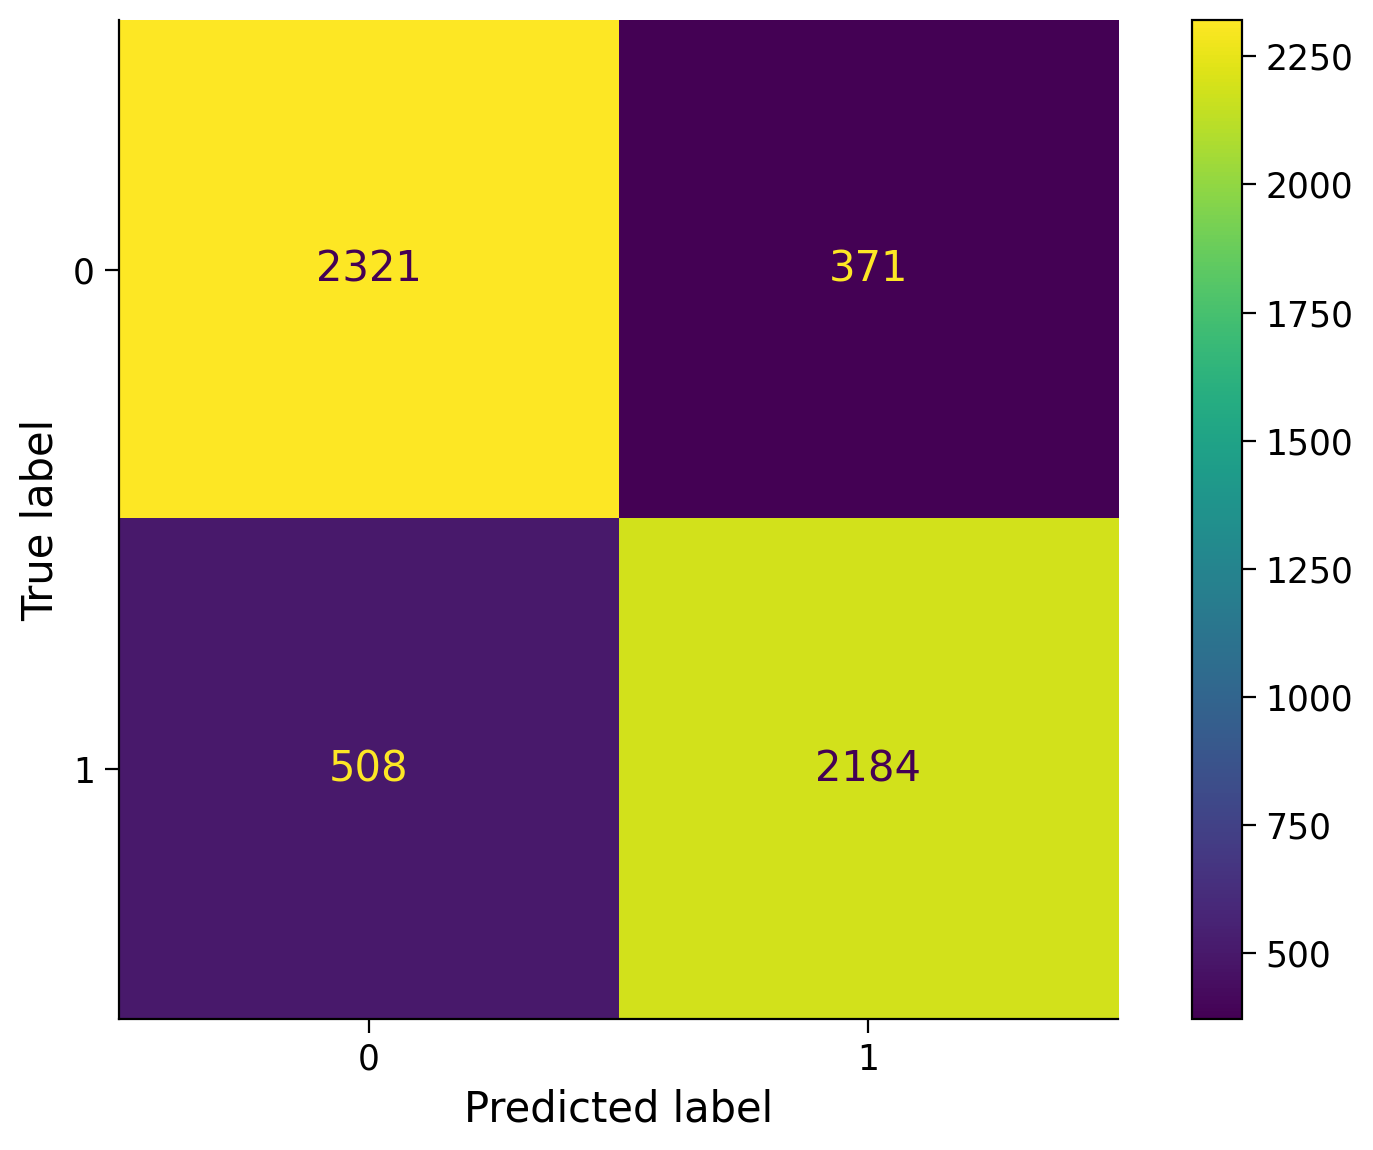

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#Accuracy test

In [ ]:
accuracy_score(y_test, yhats, normalize=True)

0.836738484398217

#Cross validation

In [ ]:
n_cv=8

cv = cross_val_score(model, X_max_act, y_max_act , cv=n_cv, scoring='recall_macro')
print(cv)

[0.83333333 0.85250737 0.86283186 0.85103245 0.87020649 0.83775811
 0.85545723 0.81268437]


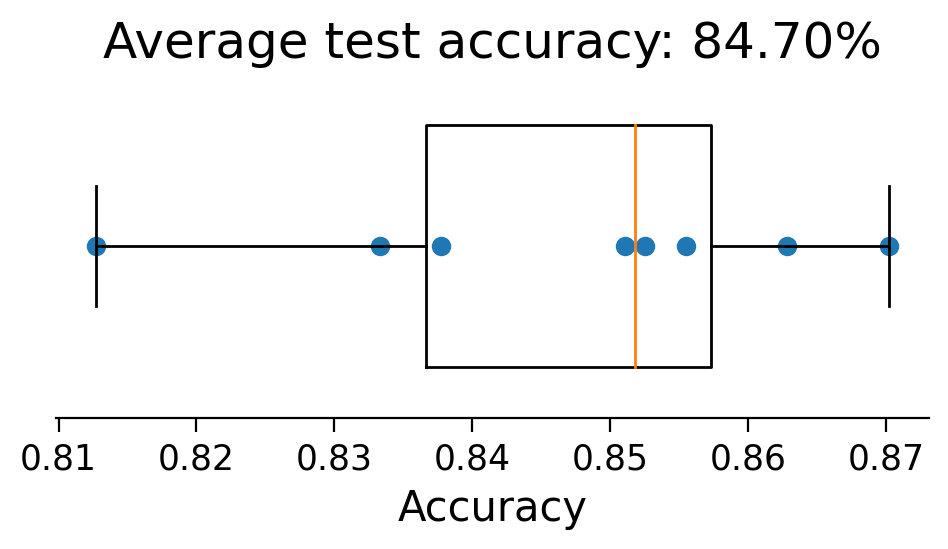

In [ ]:
#visualize cv
f, ax = plt.subplots(figsize=(5, 3))
ax.boxplot(cv, vert=False, widths=.7)
ax.scatter(cv, np.ones(n_cv))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {cv.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()